# Chapter 6
## Data cleaning, Imbalanced Data, and Other Data Problems 
This notebook is a companion to the book _XGBoost for Regression Predictive Modeling and Time Series Analysis_.
This chapter covers how to address common problems with real-life data sets and this code is a series of Python data cleaning functions. 

In [1]:
# ----------------------------------------
# filename datacleaning.ipynb
# Python functions to perform common data cleaning tasks
# author Joyce Weiner
# revision 1.0
# revision history 1.0 - initial script
# ----------------------------------------

# These functions all use pandas
import pandas as pd
import numpy as np

In [28]:
# Create a test dataframe to use to verify the functions work correctly

testdf = pd.DataFrame(np.random.randn(5250,3), columns=list("ABC"))
testdf.insert(len(testdf.columns), "category","Category A")
testdf.loc[3000:4499,["category"]] = "CategoryB"
testdf.loc[4500:5250,["category"]] = "Cat C"
testdf.insert(len(testdf.columns),"Date",np.random.choice(pd.date_range('2022-10-01', '2024-11-30'),len(testdf)))

In [29]:
print(testdf)

             A         B         C    category       Date
0    -1.822375  0.002735  0.679081  Category A 2023-11-26
1     0.244877 -1.416877 -0.001593  Category A 2022-10-30
2    -1.862232  1.016937 -0.538479  Category A 2023-01-28
3    -0.862247  0.257074  0.819732  Category A 2023-12-27
4     2.037146 -0.447522 -0.309707  Category A 2024-11-22
...        ...       ...       ...         ...        ...
5245  0.455725  0.400892 -1.826665       Cat C 2024-09-25
5246 -0.115705 -1.336463 -0.934201       Cat C 2024-07-28
5247 -1.086536  0.279270  0.246209       Cat C 2024-06-25
5248  0.921076 -0.984286  2.480446       Cat C 2024-10-03
5249 -1.032202 -0.492262 -0.105453       Cat C 2022-12-04

[5250 rows x 5 columns]


## Example of multimodal data using the Iris dataset

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# load the iris data set from scikit-learn
from sklearn import datasets

irisarray = datasets.load_iris()# bring the array into a pandas dataframe and label the headers
# have to concatenate the data and the target -- which is already converted from words to numbers
irisdata = pd.DataFrame(np.c_[irisarray['data'], irisarray['target']], columns = irisarray['feature_names'] + ['Species'])
irisdata['Species'] = irisdata['Species'].astype(int)

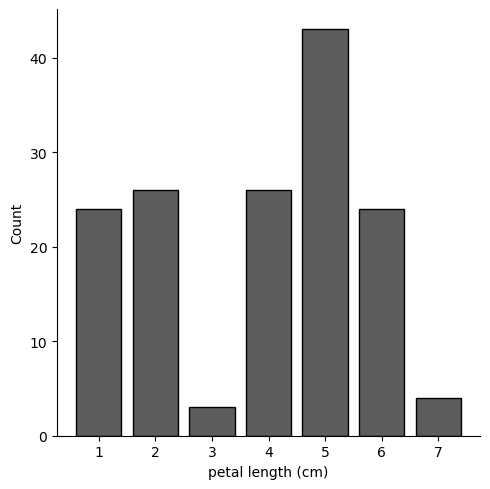

In [31]:
sns.set_palette("dark:grey")
sns.displot(irisdata, x="petal length (cm)", discrete = True, shrink =0.8)

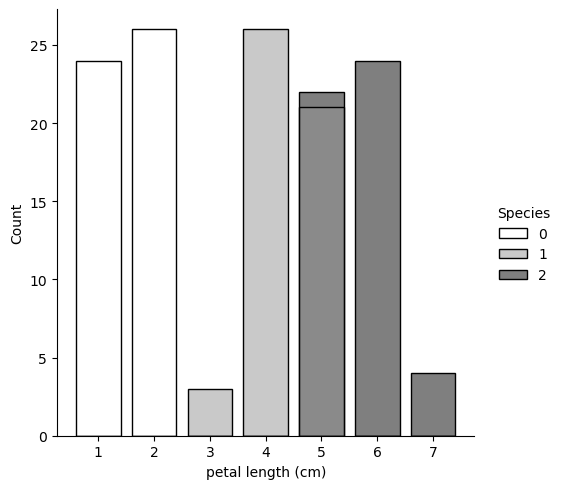

In [32]:
sns.displot(irisdata, x="petal length (cm)", discrete = True, hue = "Species", shrink =0.8, palette = "Greys")

### 4-pseudo sigma filter for continuous data

In [33]:
# Filter continuous data using a 4 pseudo sigma filter
# dataframe = pandas dataframe to modify
# parameter = name of column in dataframe to filter

def pseudosigmafilter(dataframe, parameter):
    mean = dataframe[parameter].mean()
    stdev = dataframe[parameter].std()
    lowerfiltervalue = mean - (4*stdev)
    upperfiltervalue = mean + (4*stdev)
    # print(mean)
    # print(stdev)
    # print(lowerfiltervalue)
    # print(upperfiltervalue)
    
    # Create a new column called "filter_" parameter and set to NaN if outside the limits
    dataframe["filter_" + parameter] = np.where(((dataframe[parameter] > lowerfiltervalue) & (dataframe[parameter] < upperfiltervalue)) , dataframe[parameter], np.NaN)
    return dataframe

In [34]:
# Inject a huge value in Category A and test that it is filtered
testdf.at[0,"A"] = 11

pseudosigmafilter (testdf, "A")

,A,B,C,category,Date,filter_A
0,11.000000,0.002735,0.679081,Category A,2023-11-26,NaN
1,0.244877,-1.416877,-0.001593,Category A,2022-10-30,0.244877
2,-1.862232,1.016937,-0.538479,Category A,2023-01-28,-1.862232
3,-0.862247,0.257074,0.819732,Category A,2023-12-27,-0.862247
4,2.037146,-0.447522,-0.309707,Category A,2024-11-22,2.037146
...,...,...,...,...,...,...
5245,0.455725,0.400892,-1.826665,Cat C,2024-09-25,0.455725
5246,-0.115705,-1.336463,-0.934201,Cat C,2024-07-28,-0.115705
5247,-1.086536,0.279270,0.246209,Cat C,2024-06-25,-1.086536
5248,0.921076,-0.984286,2.480446,Cat C,2024-10-03,0.921076


### Standardizing continuous data

In [35]:
from sklearn import preprocessing
continuous = testdf[["A", "B", "C"]]
continuous.head()


,A,B,C
0,11.000000,0.002735,0.679081
1,0.244877,-1.416877,-0.001593
2,-1.862232,1.016937,-0.538479
3,-0.862247,0.257074,0.819732
4,2.037146,-0.447522,-0.309707


In [36]:
standardized = preprocessing.StandardScaler().fit(continuous)

In [37]:
standardized = standardized.transform(continuous)
print (standardized)

[[ 1.08414109e+01 -6.18997249e-04  7.02263190e-01]
 [ 2.27199606e-01 -1.42795603e+00  2.03366332e-02]
 [-1.85230240e+00  1.01910168e+00 -5.17537200e-01]
 ...
 [-1.08676971e+00  2.77420784e-01  2.68595153e-01]
 [ 8.94539098e-01 -9.93011310e-01  2.50694314e+00]
 [-1.03314750e+00 -4.98310075e-01 -8.37141220e-02]]


In [38]:
standardizeddf = pd.DataFrame(standardized, columns=["A", "B", "C"] )
standardizeddf.head()

,A,B,C
0,10.841411,-0.000619,0.702263
1,0.227200,-1.427956,0.020337
2,-1.852302,1.019102,-0.517537
3,-0.865419,0.255104,0.843173
4,1.995987,-0.453327,-0.288344


In [39]:
standardizedtestdf = pd.concat([testdf, standardizeddf],axis=1)
standardizedtestdf.head()

,A,B,C,category,Date,filter_A,A,B,C
0,11.000000,0.002735,0.679081,Category A,2023-11-26,NaN,10.841411,-0.000619,0.702263
1,0.244877,-1.416877,-0.001593,Category A,2022-10-30,0.244877,0.227200,-1.427956,0.020337
2,-1.862232,1.016937,-0.538479,Category A,2023-01-28,-1.862232,-1.852302,1.019102,-0.517537
3,-0.862247,0.257074,0.819732,Category A,2023-12-27,-0.862247,-0.865419,0.255104,0.843173
4,2.037146,-0.447522,-0.309707,Category A,2024-11-22,2.037146,1.995987,-0.453327,-0.288344


#### Centering data

In [40]:
centered = preprocessing.StandardScaler(with_std=False).fit(continuous)
print(centered.transform(continuous))

[[ 1.09853390e+01 -6.15647156e-04  7.00973231e-01]
 [ 2.30215857e-01 -1.42022775e+00  2.02992777e-02]
 [-1.87689315e+00  1.01358617e+00 -5.16586558e-01]
 ...
 [-1.10119742e+00  2.75919347e-01  2.68101782e-01]
 [ 9.06414798e-01 -9.87637005e-01  2.50233824e+00]
 [-1.04686333e+00 -4.95613157e-01 -8.35603510e-02]]


### Normalizing continuous data

In [41]:
from sklearn import preprocessing
def normalizecolumn(dataframe, parameter):
    colarray = np.array(dataframe[parameter])
    normalizedarray = preprocessing.normalize([colarray]).tolist()
    normalizedarray = np.swapaxes(normalizedarray,0,1)
    dataframe["normalized_" + parameter] = normalizedarray
    return dataframe

In [42]:
normalizecolumn(testdf, "B")

,A,B,C,category,Date,filter_A,normalized_B
0,11.000000,0.002735,0.679081,Category A,2023-11-26,NaN,0.000038
1,0.244877,-1.416877,-0.001593,Category A,2022-10-30,0.244877,-0.019661
2,-1.862232,1.016937,-0.538479,Category A,2023-01-28,-1.862232,0.014111
3,-0.862247,0.257074,0.819732,Category A,2023-12-27,-0.862247,0.003567
4,2.037146,-0.447522,-0.309707,Category A,2024-11-22,2.037146,-0.006210
...,...,...,...,...,...,...,...
5245,0.455725,0.400892,-1.826665,Cat C,2024-09-25,0.455725,0.005563
5246,-0.115705,-1.336463,-0.934201,Cat C,2024-07-28,-0.115705,-0.018545
5247,-1.086536,0.279270,0.246209,Cat C,2024-06-25,-1.086536,0.003875
5248,0.921076,-0.984286,2.480446,Cat C,2024-10-03,0.921076,-0.013658


### Correcting spelling in a column

In [43]:
def cleancategory(dataframe, parameter):
    if parameter == "category":
        dataframe["clean_" + parameter] = "Category " + dataframe[parameter].str[-1]
    return dataframe

In [44]:
cleancategory(testdf, "category" )

,A,B,C,category,Date,filter_A,normalized_B,clean_category
0,11.000000,0.002735,0.679081,Category A,2023-11-26,NaN,0.000038,Category A
1,0.244877,-1.416877,-0.001593,Category A,2022-10-30,0.244877,-0.019661,Category A
2,-1.862232,1.016937,-0.538479,Category A,2023-01-28,-1.862232,0.014111,Category A
3,-0.862247,0.257074,0.819732,Category A,2023-12-27,-0.862247,0.003567,Category A
4,2.037146,-0.447522,-0.309707,Category A,2024-11-22,2.037146,-0.006210,Category A
...,...,...,...,...,...,...,...,...
5245,0.455725,0.400892,-1.826665,Cat C,2024-09-25,0.455725,0.005563,Category C
5246,-0.115705,-1.336463,-0.934201,Cat C,2024-07-28,-0.115705,-0.018545,Category C
5247,-1.086536,0.279270,0.246209,Cat C,2024-06-25,-1.086536,0.003875,Category C
5248,0.921076,-0.984286,2.480446,Cat C,2024-10-03,0.921076,-0.013658,Category C


### Reformatting date data

In [45]:
testdf["Date_new"] = testdf["Date"].dt.strftime("%d-%b-%Y")
testdf.head()

,A,B,C,category,Date,filter_A,normalized_B,clean_category,Date_new
0,11.000000,0.002735,0.679081,Category A,2023-11-26,NaN,0.000038,Category A,26-Nov-2023
1,0.244877,-1.416877,-0.001593,Category A,2022-10-30,0.244877,-0.019661,Category A,30-Oct-2022
2,-1.862232,1.016937,-0.538479,Category A,2023-01-28,-1.862232,0.014111,Category A,28-Jan-2023
3,-0.862247,0.257074,0.819732,Category A,2023-12-27,-0.862247,0.003567,Category A,27-Dec-2023
4,2.037146,-0.447522,-0.309707,Category A,2024-11-22,2.037146,-0.006210,Category A,22-Nov-2024


In [46]:
testdf["Date_US"] = testdf["Date"].dt.strftime("%m/%d/%Y")
testdf.head()

,A,B,C,category,Date,filter_A,normalized_B,clean_category,Date_new,Date_US
0,11.000000,0.002735,0.679081,Category A,2023-11-26,NaN,0.000038,Category A,26-Nov-2023,11/26/2023
1,0.244877,-1.416877,-0.001593,Category A,2022-10-30,0.244877,-0.019661,Category A,30-Oct-2022,10/30/2022
2,-1.862232,1.016937,-0.538479,Category A,2023-01-28,-1.862232,0.014111,Category A,28-Jan-2023,01/28/2023
3,-0.862247,0.257074,0.819732,Category A,2023-12-27,-0.862247,0.003567,Category A,27-Dec-2023,12/27/2023
4,2.037146,-0.447522,-0.309707,Category A,2024-11-22,2.037146,-0.006210,Category A,22-Nov-2024,11/22/2024


### Sampling data for each class to match the class with the smallest number of observations

In [47]:
# Use pandas to select a random sample by category
# dataframe = pandas dataframe to modify
# category = name of column in dataframe
# nsamples = number of rows 

def subsamplecategory(olddataframe,category,nsamples):
    newdataframe = olddataframe.groupby(category).apply(lambda s: s.sample(nsamples))
    return newdataframe

In [48]:
newdf = subsamplecategory(testdf,"category",750)
print (newdf)

                       A         B         C   category       Date  filter_A  \
category                                                                       
Cat C     4810  2.054190 -0.211156 -0.423385      Cat C 2023-06-14  2.054190   
          4887  1.036701  1.384915 -0.547349      Cat C 2022-10-28  1.036701   
          4794  0.507356 -0.310282 -1.378559      Cat C 2023-09-01  0.507356   
          5161  0.183426 -0.537936  1.674514      Cat C 2024-06-01  0.183426   
          4626 -1.087329  0.341103  0.188274      Cat C 2023-05-28 -1.087329   
...                  ...       ...       ...        ...        ...       ...   
CategoryB 4162  1.338283 -0.203879 -0.999352  CategoryB 2023-01-18  1.338283   
          4267 -0.325148  0.371814 -1.044800  CategoryB 2023-09-13 -0.325148   
          3629 -0.874404  0.917054 -0.476953  CategoryB 2022-11-29 -0.874404   
          4454  0.819380  1.752683  0.018181  CategoryB 2024-02-10  0.819380   
          4479 -0.104143  0.016466 -1.68

C:\Users\joyce\AppData\Local\Temp\ipykernel_22176\4093145083.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  newdataframe = olddataframe.groupby(category).apply(lambda s: s.sample(nsamples))
